# Ambulance Trusts

## 1 Summary

## Aims

Find the ambulance trust that covers each LSOA.

## Method

We have a data source that links 2021 CCG regions to English ambulance services. We can combine this with a lookup for LSOA to 2021 CCGs to create a list of all LSOAs in England and Wales to the ambulance services that cover them.

A few of the 2021 CCGs are listed as being covered by multiple ambulance services. We dig into those regions individually to work out how best to allocate the LSOAs. Generally the idea is to break up the large 2021 CCG into smaller subregions and assign the subregions to different ambulance services.

Note: For source of images, see 'images/image_sources.txt'.

## 2 Import packages and set file paths

In [1]:
# Import required packages
from dataclasses import dataclass
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from PIL import Image
import geopandas as gpd

In [2]:
# Define file paths
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and database.'''

    # Directories:
    image = 'external_images'
    data = 'data'
    look_ups = 'look_ups'
    dir_figures = 'figures'

    # Reference map images:
    aace = 'aace-map-all.png'
    pollitt = 'pollitt-map.png'
    hsi_ccg = 'hampshire_southampton_isleofwight_ccg.png'
    scas = 'SCAS-map.png'
    eeas = 'our-station-map.jpg'
    blmk = 'BLMK_Map.png'

    # Lookup files:
    lsoa_to_lad = (
        'LSOA_(2011)_to_LSOA_(2021)_to_Local_Authority_District' +
        '_(2022)_Lookup_for_England_and_Wales_(Version_2).csv'
    )
    lsoa_to_ccg = (
        'Lower_Layer_Super_Output_Area_(2011)_to_Clinical_' +
        'Commissioning_Group_to_Local_Authority_District_(April_' +
        '2021)_Lookup_in_England.csv'
    )
    lsoa_to_sicbl22 = (
        'LSOA_(2011)_to_Sub_ICB_Locations_(July_2022)_Lookup_in_England.csv')
    ccg21_amb_lookup = 'ccg21_amb.csv'
    sicbl22_amb_lookup = 'sicbl22_amb.csv'

    # Output:
    lsoa_ambo_results = 'lsoa_ambo_lookup.csv'

paths = Paths()

## 3 Background

### 3.1 Existing maps of ambulance boundaries

The Association of Ambulance Chief Executives provide an interactive map [on their website](https://aace.org.uk/uk-ambulance-service/map-of-nhs-ambulance-services/) (screenshot copied below) that shows the ambulance boundaries. We have been advised by Steve Irving (Executive Officer / ALF Conference Lead) that the map "is just an approximation of the boundaries, purely for illustrative / navigational purposes".

In England and Wales, there are 12 ambulance services:
1. East Midlands Ambulance Service (EMAS)
2. East of England Ambulance Service Trust (EEAST)
3. London Ambulance Service (LAS)
4. North East Ambulance Service (NEAS)
5. North West Ambulance Service (NWAS)
6. South Central Ambulance Service (SCAS)
7. South East Coast Ambulance Service (SECAmb)
8. West Midlands Ambulance Service (WMAS)
9. South West Ambulance Service (SWAS)
10. Yorkshire Ambulance Service (YAS)
11. Welsh Ambulance Service (WAS)
12. Isle of Wight Ambulance Service

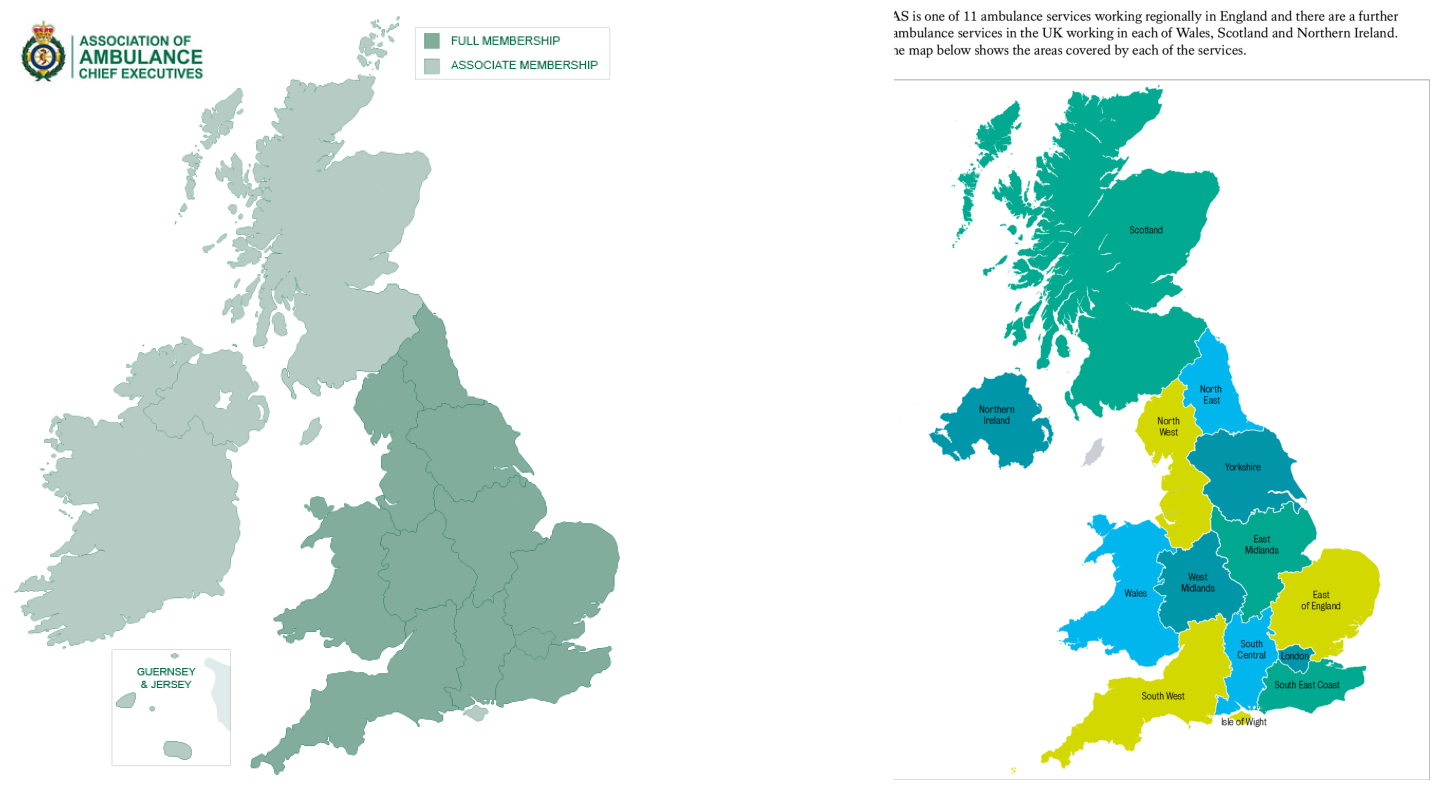

In [3]:
# Display images side-by-side
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(np.array(Image.open(os.path.join(paths.image, paths.aace))))
axs[0].axis('off')
axs[1].imshow(np.array(Image.open(os.path.join(paths.image, paths.pollitt))))
axs[1].axis('off')
plt.show()

### 3.2 Existing spreadsheets which identify ambulance boundaries

We can link together two dataframes that take us from **LSOA to CCG** and then **CCG to Ambulance Service**. The second file was created from ambulance_service_info.xlsx, with the removal of the two CCGs with complications (which did not have data in the file and just said "More than one" in the ambulance service columns.)

There are **three complications**, which are explained in more detail in their sections of the notebook below:
* NHS Hampshire, Southampton, and Isle of Wight CCG is covered by two different ambulance services
* NHS Bedfordshire, Luton and Milton Keynes CCG is covered by two different ambulance services
* Wales is not included in the spreadsheet

## 4 Create CCG to Ambulance Service based on lookup files

Load file with LSOA to CCG

In [4]:
# Load the LSOA to CCG look-up
df_lsoa_ccg21 = pd.read_csv(
    os.path.join(paths.data, paths.look_ups, paths.lsoa_to_ccg)
)

df_lsoa_ccg21.head(2)

,FID,LSOA11CD,LSOA11NM,CCG21CD,CCG21CDH,CCG21NM,LAD21CD,LAD21NM
0,1,E01007420,Barnsley 016C,E38000006,02P,NHS Barnsley CCG,E08000016,Barnsley
1,2,E01007317,Barnsley 018A,E38000006,02P,NHS Barnsley CCG,E08000016,Barnsley


Load file with CCG to ambulance trust

In [5]:
# Load the CCG to ambulance look-up
df_ccg21_ambo = pd.read_csv(
    os.path.join(paths.data, paths.ccg21_amb_lookup),
    )

# Preview dataframe
df_ccg21_ambo.head()

,CCG21CD,CCG21NM,ambo21
0,E38000007,NHS Basildon and Brentwood CCG,EEAST
1,E38000026,NHS Cambridgeshire and Peterborough CCG,EEAST
2,E38000030,NHS Castle Point and Rochford CCG,EEAST
3,E38000049,NHS East and North Hertfordshire CCG,EEAST
4,E38000079,NHS Herts Valleys CCG,EEAST


Add the CCG to Ambulance fields to the LSOA to CCG dataset (by matching on CCG name - make that the index for both datasets before joining)

In [6]:
# Join LSOA-CCG and CCG-Ambulance based on index (which is the CCG name)
df_lsoa_ambo = pd.merge(df_lsoa_ccg21, df_ccg21_ambo, on='CCG21NM', how='left')

Drop some unwanted columns now:

In [7]:
df_lsoa_ambo = df_lsoa_ambo[['LSOA11NM', 'LSOA11CD', 'CCG21NM', 'LAD21NM', 'ambo21']]

In [8]:
# Preview dataframe
df_lsoa_ambo.head()

,LSOA11NM,LSOA11CD,CCG21NM,LAD21NM,ambo21
0,Barnsley 016C,E01007420,NHS Barnsley CCG,Barnsley,YAS
1,Barnsley 018A,E01007317,NHS Barnsley CCG,Barnsley,YAS
2,Brentwood 007E,E01021475,NHS Basildon and Brentwood CCG,Brentwood,EEAST
3,Barnsley 027A,E01007421,NHS Barnsley CCG,Barnsley,YAS
4,Basildon 016D,E01021290,NHS Basildon and Brentwood CCG,Basildon,EEAST


## 5 Add NHS Hampshire, Southampton and Isle of Wight CCG

### 5.1 Maps

As you can see from the maps, this CCG includes areas from Hampshire and Isle of Wight (and does not, for example, include Portsmouth or North East Hampshire, which are part of different CCGs).

Of the areas in the CCG:
* The **South Central Ambulance Service** (SCAS) covers Hampshire
* The **Isle of Wight Ambulance Service** covers the Isle of Wight

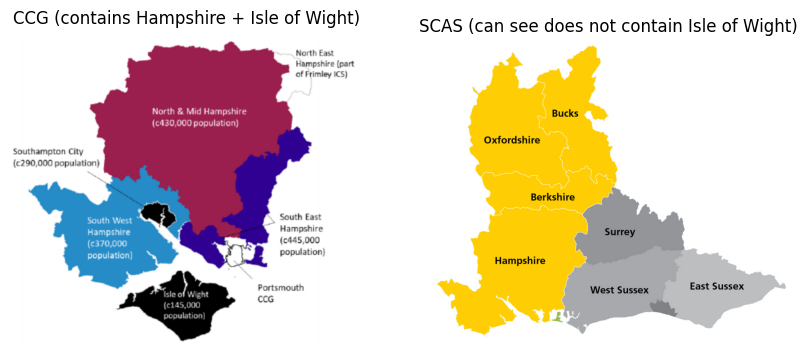

In [9]:
# Display images side-by-side
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10, 5))
ax[0].imshow(np.array(Image.open(os.path.join(paths.image, paths.hsi_ccg))))
ax[0].axis('off')
ax[0].set_title('CCG (contains Hampshire + Isle of Wight)')
ax[1].imshow(np.array(Image.open(os.path.join(paths.image, paths.scas))))
ax[1].axis('off')
ax[1].set_title('SCAS (can see does not contain Isle of Wight)')
plt.show()

### 5.2 Add appropriate service to each LSOA

Assign LSOAs in Isle of Wight to the Isle of Wight Ambulance Service. Assign the remaining LSOAs to the South Central Ambulance Service.

In [10]:
# Find LSOAs in that CCG
mask = df_lsoa_ambo['CCG21NM'].str.contains('Hampshire')
# Set the ambulance service as South Central (SCAS)
df_lsoa_ambo.loc[mask, 'ambo21'] = 'SCAS'

# From those LSOAs, identify those that are in the Isle of Wight
mask2 = df_lsoa_ambo['LSOA11NM'].str.contains('Isle of Wight')
# Replace the ambulance service for those to Isle of Wight
df_lsoa_ambo.loc[mask2, 'ambo21'] = 'IWAS'

# View resulting number of LSOA from that CCG in each service
df_lsoa_ambo.loc[mask, 'ambo21'].value_counts()

SCAS    879
IWAS     89
Name: ambo21, dtype: int64

## 6 Add NHS Bedfordshire, Luton and Milton Keynes CCG

### 6.1 Maps and information about the area

This CCG contains:

| Local authority | County |
| --- | --- |
| Central Bedfordshire | Bedfordshire |
| Luton | Bedfordshire |
| Bedford | Bedfordshire |
| Milton Keynes | Buckinghamshire |
| Buckinghamshire | Buckinghamshire |

In [11]:
df_lsoa_ccg21.loc[df_lsoa_ccg21['CCG21NM'] == 'NHS Bedfordshire, Luton and Milton Keynes CCG', 'LAD21NM'].value_counts()

Central Bedfordshire    157
Milton Keynes           152
Luton                   121
Bedford                 103
Buckinghamshire           4
Name: LAD21NM, dtype: int64

It is covered by two ambulance services: (1) East of England Ambulance Service, and (2) South Central Ambulance Service. 

The two reference maps appear to be built out of county borders rather than CCG borders.

Both of these reference maps (SCAS and EEAS) lay claim to Milton Keynes (top-right of Bucks on the SCAS map and left-hand-side of Bedfordshire on the EEAS map). 

The most sensible way to split the two maps so that the 2021 CCG is partly covered by SCAS and partly by EEAST is to assign Milton Keynes to SCAS and the rest of Bedfordshire to EEAST.

__In terms of CCGs:__ 

This split possibly comes from the 2015 CCG boundaries where there were many more smaller CCGs than in the 2021 CCG boundaries used in the ambulance service lookup table. In 2015, there was a separate "NHS Milton Keynes CCG". The area covered by that CCG was later absorbed into the "NHS Bedfordshire, Luton and Milton Keynes CCG". This new CCG is mostly covered by the East of England Ambulance Service, but the Milton Keynes area is covered by the South Central Ambulance Service.

An oddity is that the Frimley CCG does not follow county borders. It contains parts of Surrey, Hampshire, and Berkshire. Because the SCAS reference map uses counties instead of CCGs, the map claims that parts of Frimley are covered by SCAS, but separately the reference CCG-ambulance lookup table doesn't mention this and places all of the 2021 Frimley CCG under South-East Coast Ambulance Service.

__In terms of counties:__ 

To deal with this:

* LSOAs in Bedfordshire were assigned to East of England Ambulance Service
* LSOAs in Buckinghamshire were assigned to South Central Ambulance Service

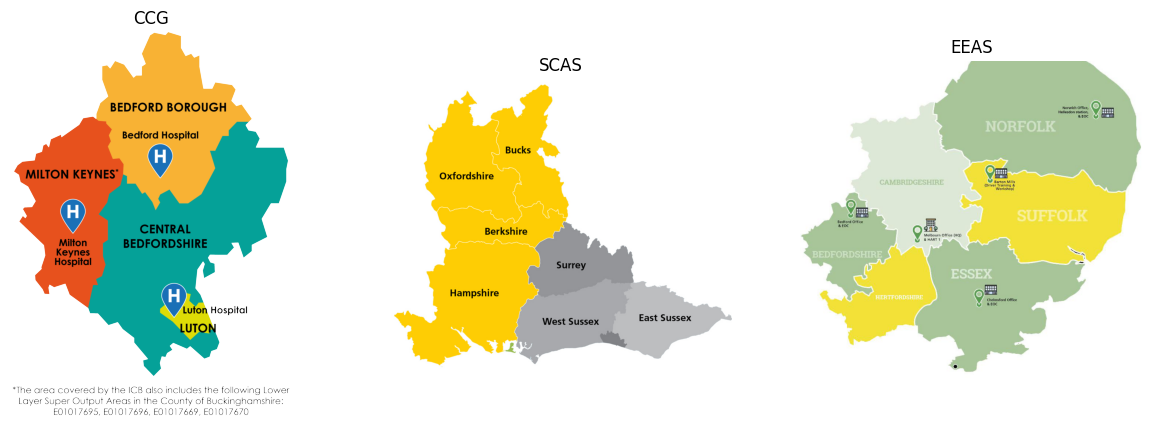

In [12]:
# Display images side-by-side
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(15, 5))
ax[0].imshow(np.array(Image.open(os.path.join(paths.image, paths.blmk))))
ax[0].axis('off')
ax[0].set_title('CCG')
ax[1].imshow(np.array(Image.open(os.path.join(paths.image, paths.scas))))
ax[1].axis('off')
ax[1].set_title('SCAS')
ax[2].imshow(np.array(Image.open(os.path.join(paths.image, paths.eeas))))
ax[2].axis('off')
ax[2].set_title('EEAS')
plt.show()

The following figure recreates the two reference maps from SCAS and EEAS using CCG boundaries:

![Recreating the reference ambulance service maps for SCAS and EEAST using CCG boundaries in 2021 and in 2015.](figures/ambo_scas_eeast_ccg21_ccg15.png)

And the following figure picks out just Milton Keynes to show how it falls into the 2021 CCG and the ambulance service regions.

Note: the 2015 "NHS Milton Keynes CCG" covers the same area as the 2021 "Milton Keynes" Local Authority District.

![The Milton Keynes CCG shown in separate maps as either part of the "NHS Bedfordshire, Luton and Milton Keynes CCG" or as part of the "South Central Ambulance Service" region.](figures/ambo_milton_keynes.png)

Notes:
+ Milton Keynes is included in both the EEAS and SCAS reference maps. It can be split off nicely and placed into SCAS using the 2015 CCGs, but not the larger 2021 CCGs.
+ The Isle of Wight is included in SCAS under the 2021 CCG map but can be split off nicely using the 2015 CCGs.
+ The drawn SCAS border doesn't match the reference map in Frimley CCG for the reasons noted previously.

### 6.2 Add appropriate services based on county

In [13]:
# Identify LSOAs from the CCG in Bedfordshire
bed_mask = (
    (df_lsoa_ambo['CCG21NM'] == 'NHS Bedfordshire, Luton and Milton Keynes CCG') &
    (df_lsoa_ambo['LAD21NM'].isin(['Central Bedfordshire', 'Luton', 'Bedford']))
)

# Set ambulance service to East of England
df_lsoa_ambo.loc[bed_mask, 'ambo21'] = 'EEAST'

In [14]:
# Identify LSOAs from the CCG in Buckinghamshire
buc_mask = (
    (df_lsoa_ambo['CCG21NM'] == 'NHS Bedfordshire, Luton and Milton Keynes CCG') &
    (df_lsoa_ambo['LAD21NM'].isin(['Milton Keynes', 'Buckinghamshire']))
)

# Set ambulance service to South Central
df_lsoa_ambo.loc[buc_mask, 'ambo21'] = 'SCAS'

## 7. 2022 Boundaries

Calculate ambulance catchment for SICBL 2022

Most other geography lookup files we've created for stroke projects use SICBL 2022. Check whether the boundary changes from CCG 2021 to SICBL 2022 affect the ambulance service boundaries.

Yes they do - to do, make a changelog of LSOA that changed. Affects near Manchester/Derbyshire and near Kettering/Peterborough.

Import an LSOA-SICBL lookup:

In [15]:
df_lsoa_sicbl22 = pd.read_csv(os.path.join(paths.data, paths.look_ups, paths.lsoa_to_sicbl22))
# Drop unwanted columns:
df_lsoa_sicbl22 = df_lsoa_sicbl22.drop(['FID', 'SICBL22CDH'], axis='columns')

df_lsoa_sicbl22.head()

,LSOA11CD,LSOA11NM,SICBL22CD,SICBL22NM
0,E01012367,Halton 007A,E38000068,NHS Cheshire and Merseyside ICB - 01F
1,E01012368,Halton 003A,E38000068,NHS Cheshire and Merseyside ICB - 01F
2,E01012369,Halton 005A,E38000068,NHS Cheshire and Merseyside ICB - 01F
3,E01012370,Halton 007B,E38000068,NHS Cheshire and Merseyside ICB - 01F
4,E01012371,Halton 016A,E38000068,NHS Cheshire and Merseyside ICB - 01F


### Check problem area changes

Check if the problem CCGs are unchanged between 2021 and 2022. If they are unchanged then their codes will be the same.

In [16]:
print(df_ccg21_ambo.loc[df_ccg21_ambo['CCG21NM'] == 'NHS Hampshire, Southampton and Isle of Wight CCG', 'CCG21CD'].values[0])
print(df_lsoa_sicbl22.loc[df_lsoa_sicbl22['SICBL22NM'] == 'NHS Hampshire and Isle of Wight ICB - D9Y0V', 'SICBL22CD'].values[0])

E38000253
E38000253


In [17]:
print(df_ccg21_ambo.loc[df_ccg21_ambo['CCG21NM'] == 'NHS Bedfordshire, Luton and Milton Keynes CCG', 'CCG21CD'].values[0])
print(df_lsoa_sicbl22.loc[df_lsoa_sicbl22['SICBL22NM'] == 'NHS Bedfordshire, Luton and Milton Keynes ICB - M1J4Y', 'SICBL22CD'].values[0])

E38000249
E38000249


The region boundaries did not change between 2021 and 2022 so we can use the same LSOA-level ambulance service lookup for both.

### Make LSOA-level ambulance lookup for SICBL 2022

Import a SICBL22-ambulance service lookup that we've invented.

These assigned ambulance services give the closest match possible to the 2021 data.

In [18]:
# Build ambulance service shapes from SICBL 2022:
df_sicbl22_ambo = pd.read_csv(os.path.join(paths.data, paths.sicbl22_amb_lookup))

df_sicbl22_ambo

,LOC22CD,LOC22NM,ambo22
0,E38000260,NHS Cambridgeshire and Peterborough ICB - 06H,EEAST
1,E38000049,NHS Hertfordshire and West Essex ICB - 06K,EEAST
2,E38000079,NHS Hertfordshire and West Essex ICB - 06N,EEAST
3,E38000197,NHS Hertfordshire and West Essex ICB - 07H,EEAST
4,E38000106,NHS Mid and South Essex ICB - 06Q,EEAST
...,...,...,...
101,E38000025,NHS West Yorkshire ICB - 02T,YAS
102,E38000190,NHS West Yorkshire ICB - 03R,YAS
103,E38000225,NHS West Yorkshire ICB - 15F,YAS
104,E38000232,NHS West Yorkshire ICB - 36J,YAS


Use the LSOA-SICBL22 and SICBL22-ambo lookups for all regions except those containing Milton Keynes and the Isle of Wight. Those regions are given a placeholder `ambo22` value of "multiple" and so can be picked out later.

First combine the two dataframes as they are:

In [19]:
df_lsoa_ambo22 = pd.merge(
    df_lsoa_sicbl22, df_sicbl22_ambo,
    left_on='SICBL22CD', right_on='LOC22CD',
    how='left'
)

df_lsoa_ambo22 = df_lsoa_ambo22.drop(['LOC22CD', 'LOC22NM'], axis='columns')

In [20]:
df_lsoa_ambo22.head()

,LSOA11CD,LSOA11NM,SICBL22CD,SICBL22NM,ambo22
0,E01012367,Halton 007A,E38000068,NHS Cheshire and Merseyside ICB - 01F,NWAS
1,E01012368,Halton 003A,E38000068,NHS Cheshire and Merseyside ICB - 01F,NWAS
2,E01012369,Halton 005A,E38000068,NHS Cheshire and Merseyside ICB - 01F,NWAS
3,E01012370,Halton 007B,E38000068,NHS Cheshire and Merseyside ICB - 01F,NWAS
4,E01012371,Halton 016A,E38000068,NHS Cheshire and Merseyside ICB - 01F,NWAS


Now sort out the problem counties. 

Separately add in the data for regions containing Milton Keynes and the Isle of Wight by first making the data as missing in this dataframe, and then using `combine_first()` to fill in the missing data using the 2021 dataframe.

In [21]:
# Replace placeholder "multiple" ambulance service code with missing value:
df_lsoa_ambo22.loc[df_lsoa_ambo22['ambo22'] == 'multiple', 'ambo22'] = pd.NA

In [22]:
# Merge in ambulance service from the CCG21 lookup.

# Set both the 2021 and 2022 data to share an index column (LSOA 2011 codes)
# and the ambulance service column name.
# Also remove excess columns from the 2021 data.
df21 = df_lsoa_ambo.copy().set_index('LSOA11CD')[['LSOA11NM', 'ambo21']]
df22 = df_lsoa_ambo22.set_index('LSOA11CD')

df21 = df21.rename(columns={'ambo21': 'ambo22'})

# Take the data from 2022 unless it is missing, in which case use 2021:
df_lsoa_ambo22 = df22.combine_first(df21)#, axis='columns')

In [23]:
df_lsoa_ambo22

,LSOA11NM,SICBL22CD,SICBL22NM,ambo22
LSOA11CD,,,,
E01000001,City of London 001A,E38000255,NHS North East London ICB - A3A8R,LAS
E01000002,City of London 001B,E38000255,NHS North East London ICB - A3A8R,LAS
E01000003,City of London 001C,E38000255,NHS North East London ICB - A3A8R,LAS
E01000005,City of London 001E,E38000255,NHS North East London ICB - A3A8R,LAS
E01000006,Barking and Dagenham 016A,E38000255,NHS North East London ICB - A3A8R,LAS
...,...,...,...,...
E01033764,Liverpool 022E,E38000101,NHS Cheshire and Merseyside ICB - 99A,NWAS
E01033765,Liverpool 061D,E38000101,NHS Cheshire and Merseyside ICB - 99A,NWAS
E01033766,Liverpool 042G,E38000101,NHS Cheshire and Merseyside ICB - 99A,NWAS


Check whether anything has been left blank. This should return False:

In [24]:
df_lsoa_ambo22['ambo22'].isna().any()

False

### Combine 2021 and 2022 data

Create a dataframe containing LSOA names and codes and ambulance service codes for 2021 and for 2022.

In [25]:
# Prepare for merge:
df_lsoa_ambo22 = df_lsoa_ambo22.reset_index()[['LSOA11CD', 'ambo22']]

df_lsoa_ambo = pd.merge(
    df_lsoa_ambo, df_lsoa_ambo22,
    on='LSOA11CD', how='left'
)

The combined data:

In [26]:
df_lsoa_ambo.head()

,LSOA11NM,LSOA11CD,CCG21NM,LAD21NM,ambo21,ambo22
0,Barnsley 016C,E01007420,NHS Barnsley CCG,Barnsley,YAS,YAS
1,Barnsley 018A,E01007317,NHS Barnsley CCG,Barnsley,YAS,YAS
2,Brentwood 007E,E01021475,NHS Basildon and Brentwood CCG,Brentwood,EEAST,EEAST
3,Barnsley 027A,E01007421,NHS Barnsley CCG,Barnsley,YAS,YAS
4,Basildon 016D,E01021290,NHS Basildon and Brentwood CCG,Basildon,EEAST,EEAST


Quick check of the LSOA that should have different ambulance service catchment:

In [27]:
df_lsoa_ambo[df_lsoa_ambo['ambo21'] != df_lsoa_ambo['ambo22']]

,LSOA11NM,LSOA11CD,CCG21NM,LAD21NM,ambo21,ambo22
1287,East Northamptonshire 002A,E01027031,NHS Cambridgeshire and Peterborough CCG,North Northamptonshire,EEAST,EMAS
1294,East Northamptonshire 001A,E01027033,NHS Cambridgeshire and Peterborough CCG,North Northamptonshire,EEAST,EMAS
1301,East Northamptonshire 001B,E01027043,NHS Cambridgeshire and Peterborough CCG,North Northamptonshire,EEAST,EMAS
1353,East Northamptonshire 002B,E01027044,NHS Cambridgeshire and Peterborough CCG,North Northamptonshire,EEAST,EMAS
1358,East Northamptonshire 002C,E01027046,NHS Cambridgeshire and Peterborough CCG,North Northamptonshire,EEAST,EMAS
1364,East Northamptonshire 002D,E01027047,NHS Cambridgeshire and Peterborough CCG,North Northamptonshire,EEAST,EMAS
1370,East Northamptonshire 002E,E01027048,NHS Cambridgeshire and Peterborough CCG,North Northamptonshire,EEAST,EMAS
1419,East Northamptonshire 002F,E01027049,NHS Cambridgeshire and Peterborough CCG,North Northamptonshire,EEAST,EMAS
1421,East Northamptonshire 001C,E01027050,NHS Cambridgeshire and Peterborough CCG,North Northamptonshire,EEAST,EMAS
9858,High Peak 004A,E01019727,NHS Tameside and Glossop CCG,High Peak,NWAS,EMAS


## 8. Add Wales

Wales was not included in the lookup files used to create df_lsoa_ambo. Wales is covered by a single ambulance service.

In [28]:
# Import file with LSOA to Local Authority for England and Wales
lsoa_lad = pd.read_csv(os.path.join(paths.data, paths.look_ups, paths.lsoa_to_lad))

In [29]:
lsoa_lad.head()

,ObjectId,LSOA11CD,LSOA11NM,LSOA21CD,LSOA21NM,LAD22CD,LAD22NM,LAD22NMW
0,1,E01000001,City of London 001A,E01000001,City of London 001A,E09000001,City of London,NaN
1,2,E01000002,City of London 001B,E01000002,City of London 001B,E09000001,City of London,NaN
2,3,E01000003,City of London 001C,E01000003,City of London 001C,E09000001,City of London,NaN
3,4,E01000005,City of London 001E,E01000005,City of London 001E,E09000001,City of London,NaN
4,5,E01000006,Barking and Dagenham 016A,E01000006,Barking and Dagenham 016A,E09000002,Barking and Dagenham,NaN


Copy in the Welsh LSOA names and codes:

In [30]:
df_lsoa_ambo = pd.merge(
    df_lsoa_ambo, lsoa_lad[['LSOA11CD', 'LSOA11NM']],
    on='LSOA11CD', how='right', suffixes=['_Eng', None]
)

# Drop duplicate column:
df_lsoa_ambo = df_lsoa_ambo.drop('LSOA11NM_Eng', axis='columns')

In [31]:
df_lsoa_ambo

,LSOA11CD,CCG21NM,LAD21NM,ambo21,ambo22,LSOA11NM
0,E01000001,NHS North East London CCG,City of London,LAS,LAS,City of London 001A
1,E01000002,NHS North East London CCG,City of London,LAS,LAS,City of London 001B
2,E01000003,NHS North East London CCG,City of London,LAS,LAS,City of London 001C
3,E01000005,NHS North East London CCG,City of London,LAS,LAS,City of London 001E
4,E01000006,NHS North East London CCG,Barking and Dagenham,LAS,LAS,Barking and Dagenham 016A
...,...,...,...,...,...,...
34748,W01001697,NaN,NaN,NaN,NaN,Cardiff 036D
34749,W01001698,NaN,NaN,NaN,NaN,Cardiff 036E
34750,W01001699,NaN,NaN,NaN,NaN,Cardiff 049A
34751,W01001702,NaN,NaN,NaN,NaN,Cardiff 045A


Set ambulance service to Wales to all LSOA in Wales

In [32]:
# Find LSOA in Wales and set ambulance service to Welsh
mask = df_lsoa_ambo['LSOA11CD'].str.startswith('W')
df_lsoa_ambo.loc[mask, 'ambo21'] = 'WAST'
df_lsoa_ambo.loc[mask, 'ambo22'] = 'WAST'

# Preview dataframe
df_lsoa_ambo

,LSOA11CD,CCG21NM,LAD21NM,ambo21,ambo22,LSOA11NM
0,E01000001,NHS North East London CCG,City of London,LAS,LAS,City of London 001A
1,E01000002,NHS North East London CCG,City of London,LAS,LAS,City of London 001B
2,E01000003,NHS North East London CCG,City of London,LAS,LAS,City of London 001C
3,E01000005,NHS North East London CCG,City of London,LAS,LAS,City of London 001E
4,E01000006,NHS North East London CCG,Barking and Dagenham,LAS,LAS,Barking and Dagenham 016A
...,...,...,...,...,...,...
34748,W01001697,NaN,NaN,WAST,WAST,Cardiff 036D
34749,W01001698,NaN,NaN,WAST,WAST,Cardiff 036E
34750,W01001699,NaN,NaN,WAST,WAST,Cardiff 049A
34751,W01001702,NaN,NaN,WAST,WAST,Cardiff 045A


## 9. Tidy up data

In [33]:
# Reorder columns, remove CCG and LAD info:
df_lsoa_ambo = df_lsoa_ambo[['LSOA11NM', 'LSOA11CD', 'ambo21', 'ambo22']]
# Sort by LSOA name:
df_lsoa_ambo = df_lsoa_ambo.sort_values('LSOA11NM')

df_lsoa_ambo.head()

,LSOA11NM,LSOA11CD,ambo21,ambo22
30710,Adur 001A,E01031349,SECAmb,SECAmb
30711,Adur 001B,E01031350,SECAmb,SECAmb
30712,Adur 001C,E01031351,SECAmb,SECAmb
30713,Adur 001D,E01031352,SECAmb,SECAmb
30731,Adur 001E,E01031370,SECAmb,SECAmb


Check all LSOA have an ambulance service

In [34]:
df_lsoa_ambo['ambo21'].value_counts(dropna=False)

LAS       4835
NWAS      4521
EEAST     3623
WMAS      3487
SWAS      3285
SECAmb    3118
YAS       3107
EMAS      2951
SCAS      2171
WAST      1909
NEAS      1657
IWAS        89
Name: ambo21, dtype: int64

In [35]:
df_lsoa_ambo['ambo22'].value_counts(dropna=False)

LAS       4835
NWAS      4500
EEAST     3614
WMAS      3487
SWAS      3285
SECAmb    3118
YAS       3107
EMAS      2981
SCAS      2171
WAST      1909
NEAS      1657
IWAS        89
Name: ambo22, dtype: int64

## 10. Save file

Save as csv

In [36]:
df_lsoa_ambo.to_csv(os.path.join(paths.data, paths.lsoa_ambo_results), index=False)